# Libraries
---

In [61]:
# Data Handling
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import pylab

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Saving
import pickle


# II. Data Loading
---

In [62]:
# Read data
df = pd.read_csv('./data_for_modelling.csv')

# Show 5 data
df.head()

,date,status,fulfilment,sales_channel,ship_service_level,category,size,amazon_standard_id,qty,currency,sales,clean_ship_state,promotion_used
0,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,B07WV4JV4D,1,INR,329.0,Maharashtra,True
1,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Top,3XL,B098714BZP,1,INR,574.0,Tamil Nadu,False
2,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,XL,B08YN7XDSG,1,INR,824.0,Uttar Pradesh,True
3,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,L,B08CMHNWBN,1,INR,653.0,Chandigarh,True
4,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XXL,B08B3XF5MH,1,INR,363.0,Tamil Nadu,False


In [63]:
# Show info from data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77692 entries, 0 to 77691
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                77692 non-null  object 
 1   status              77692 non-null  object 
 2   fulfilment          77692 non-null  object 
 3   sales_channel       77692 non-null  object 
 4   ship_service_level  77692 non-null  object 
 5   category            77692 non-null  object 
 6   size                77692 non-null  object 
 7   amazon_standard_id  77692 non-null  object 
 8   qty                 77692 non-null  int64  
 9   currency            77692 non-null  object 
 10  sales               77692 non-null  float64
 11  clean_ship_state    77692 non-null  object 
 12  promotion_used      77692 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 7.2+ MB


In [64]:
# Change data type feature date to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by feature sales and quantity
df1 = df.groupby('date').agg(
    sales_sum=('sales', 'sum'), # sales is aggregated by summing
    qty_sum=('qty', 'sum') # qty is aggregated by averaging
).reset_index().sort_values('date')

# Set feature date as index
df1 = df1.set_index('date')

In [65]:
# Show info
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2022-03-31 to 2022-06-29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sales_sum  91 non-null     float64
 1   qty_sum    91 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 2.1 KB


In [66]:
# Knowing the frequency of the Day index
freq = pd.infer_freq(df1.index)
print(freq)

D


# III. Data Overview
---

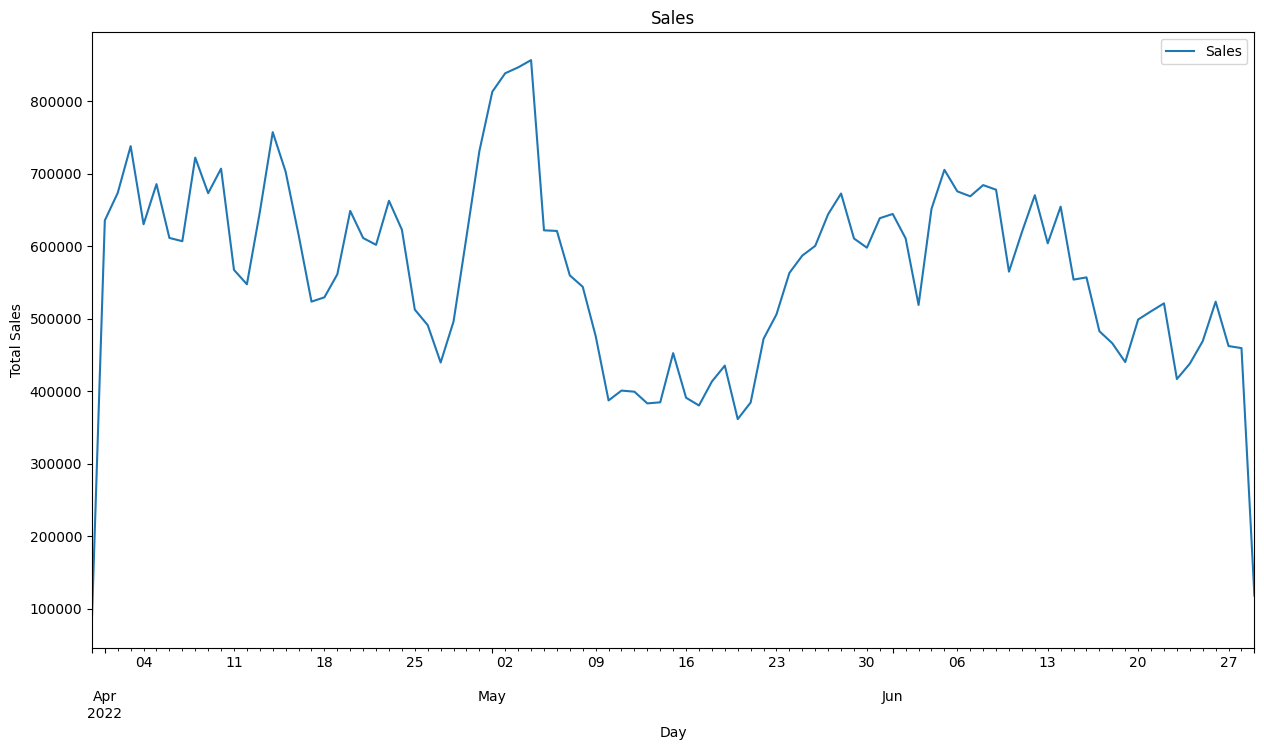

In [67]:
# Plot data
df1['sales_sum'].plot(figsize=(15,8), label='Sales')
plt.title('Sales')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


Based on our personal judgment, the number of sales at the beginning and end dates of the dataset does not accurately represent the overall data for those days, which may introduce bias. Therefore, the data on those dates will be dropped.

In [68]:
# Drop rows by first and last index
df1 = df1.drop([df1.index[0], df1.index[-1]])

# describe data
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
sales_sum,89.0,574595.825843,116275.763966,361256.0,482452.0,597695.0,651189.0,856411.0
qty_sum,89.0,872.831461,193.739295,531.0,724.0,868.0,1003.0,1374.0


## Decomposing
---

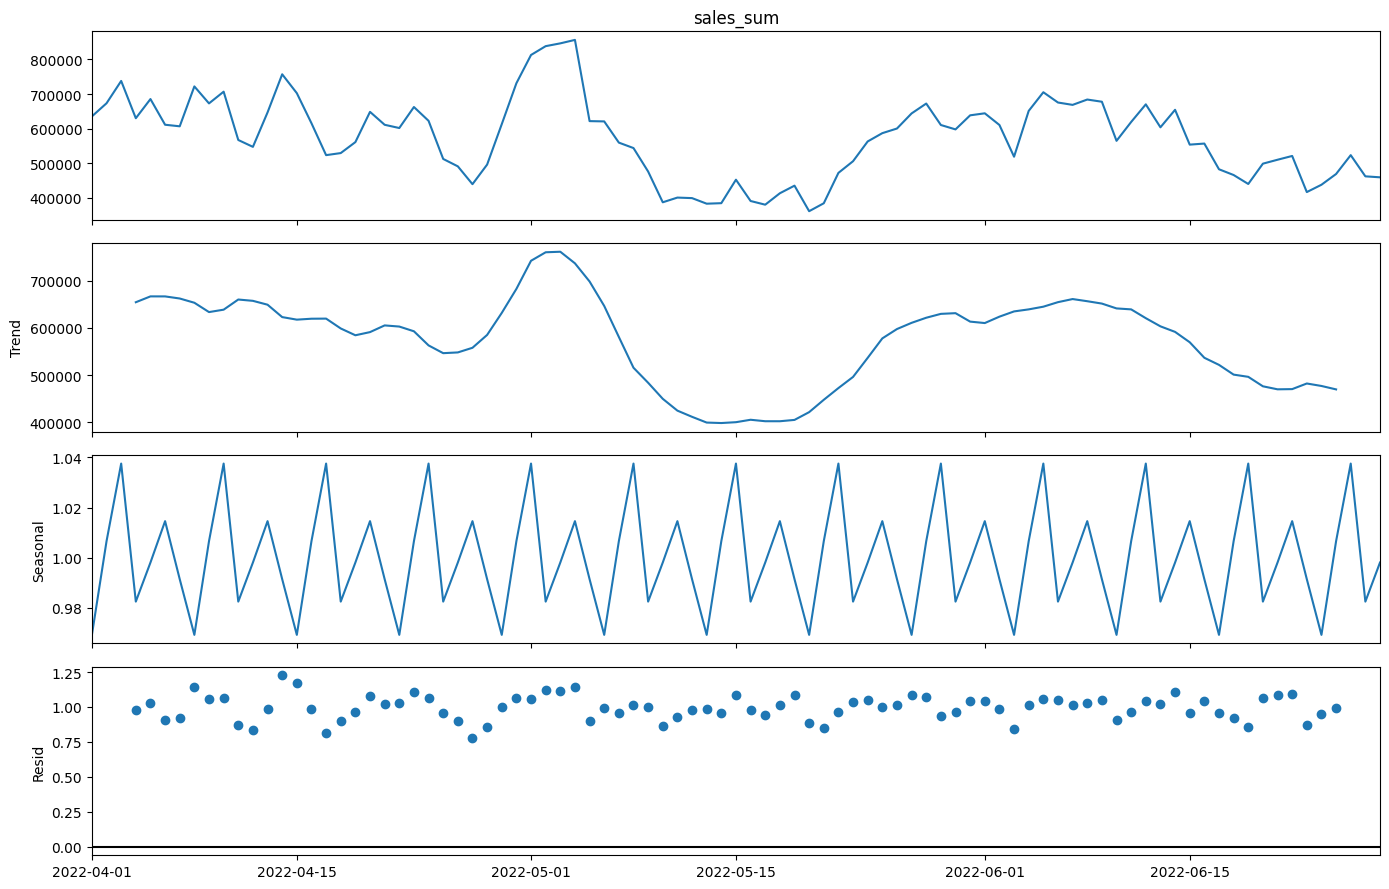

In [69]:
# Decompose the components from the time series.
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df1['sales_sum'], model='multiplicative', period=7) # interval data: Day
ax=res.plot()
plt.show()

## Splitting Data
---

In [70]:
# knowing the length of data
len(df1)

89

In [71]:
# Use train : test -> 90% : 10%
train_len = int(len(df1) * 0.90)
train_len

80

In [72]:
# Splitting train dan test
train = df1[:train_len]
test = df1[train_len:]

# Print train and test size
print('Train size: ', train.shape)
print('Test size: ', test.shape)

Train size:  (80, 2)
Test size:  (9, 2)


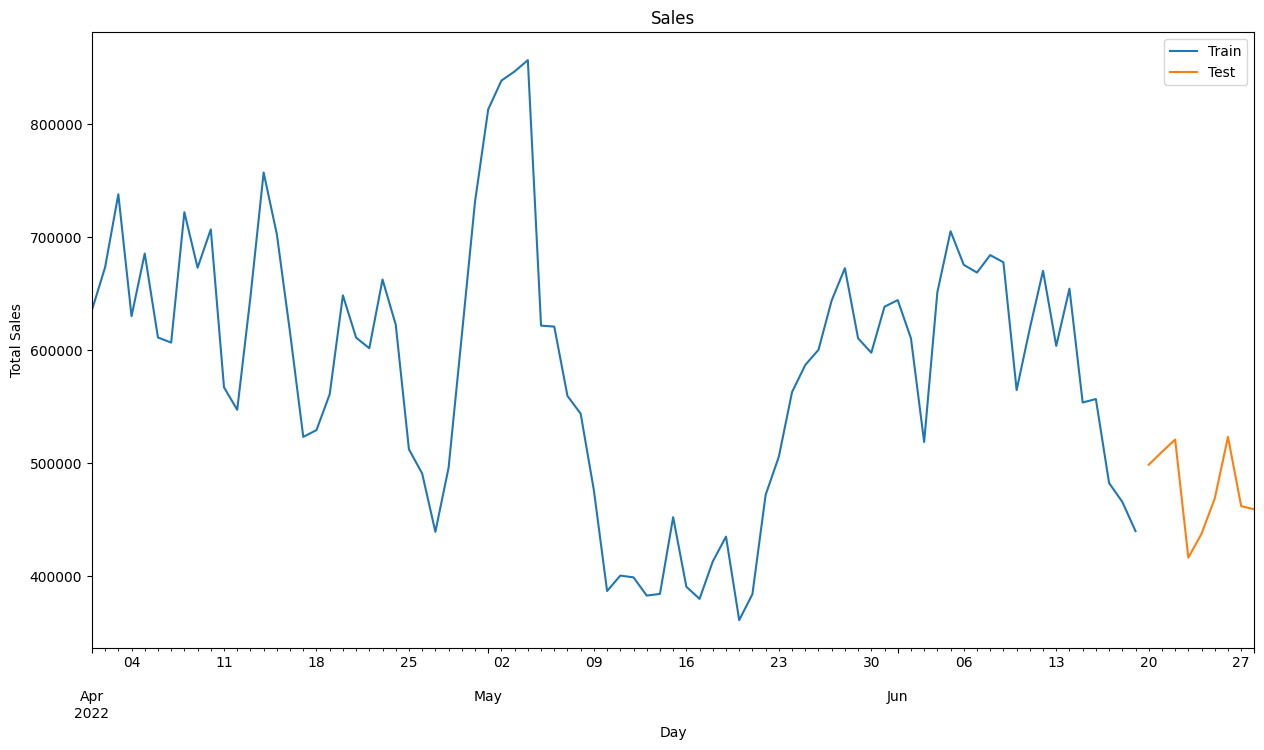

In [73]:
# Plot data train and test
train.sales_sum.plot(figsize=(15,8), label='Train')
test.sales_sum.plot(figsize=(15,8), label='Test')
plt.title('Sales')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


## Check Stationarity
---

H0: The data has a unit root and the data becomes non-stationary

H1: The data does not have a unit root and the data becomes stationary

In [74]:
# Create a function to check stationarity

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [75]:
# Check stationary of data
check_stationarity(df1['sales_sum'])

ADF Statistic: -2.904593
p-value: 0.044817
Critical Values:
	1%: -3.508
	5%: -2.895
	10%: -2.585
Stationary


alpha = 0.05

p-value < alpha then H0 is rejected, which means the data does not have a unit root and the data is stationary. Since the data is stationary, no differencing is performed and the value of parameter d is 0.

## ACF & PACF
---

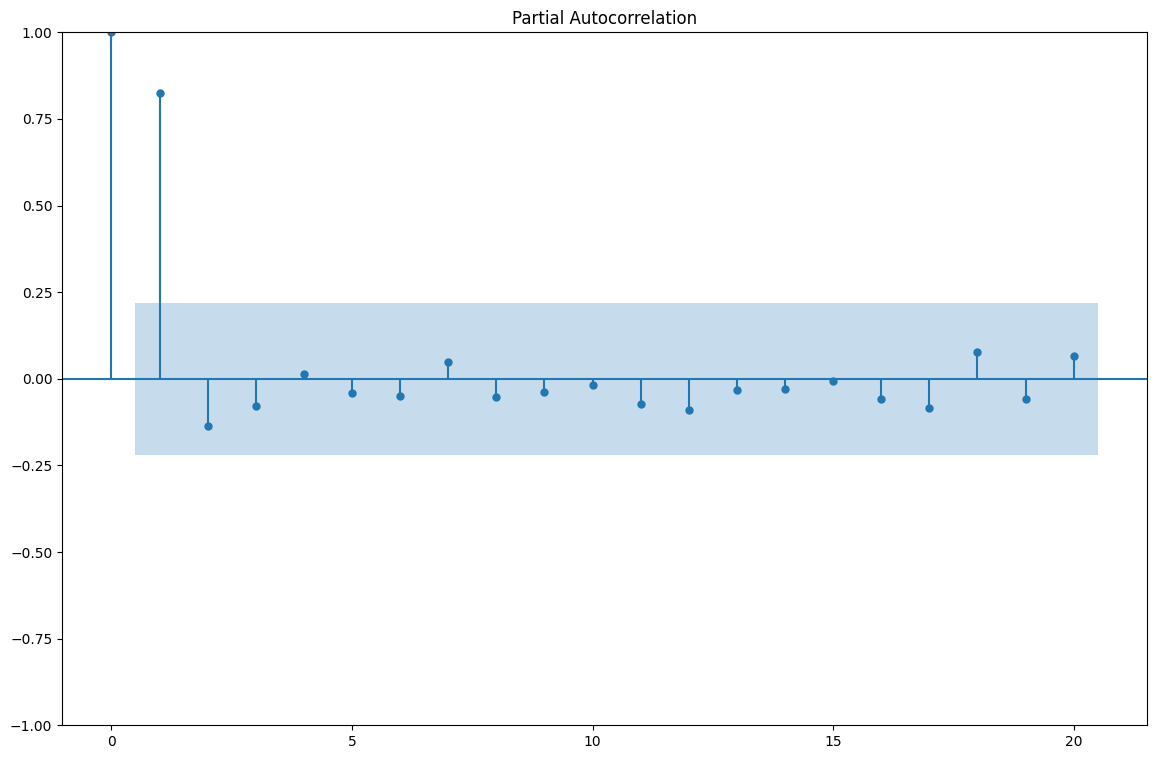

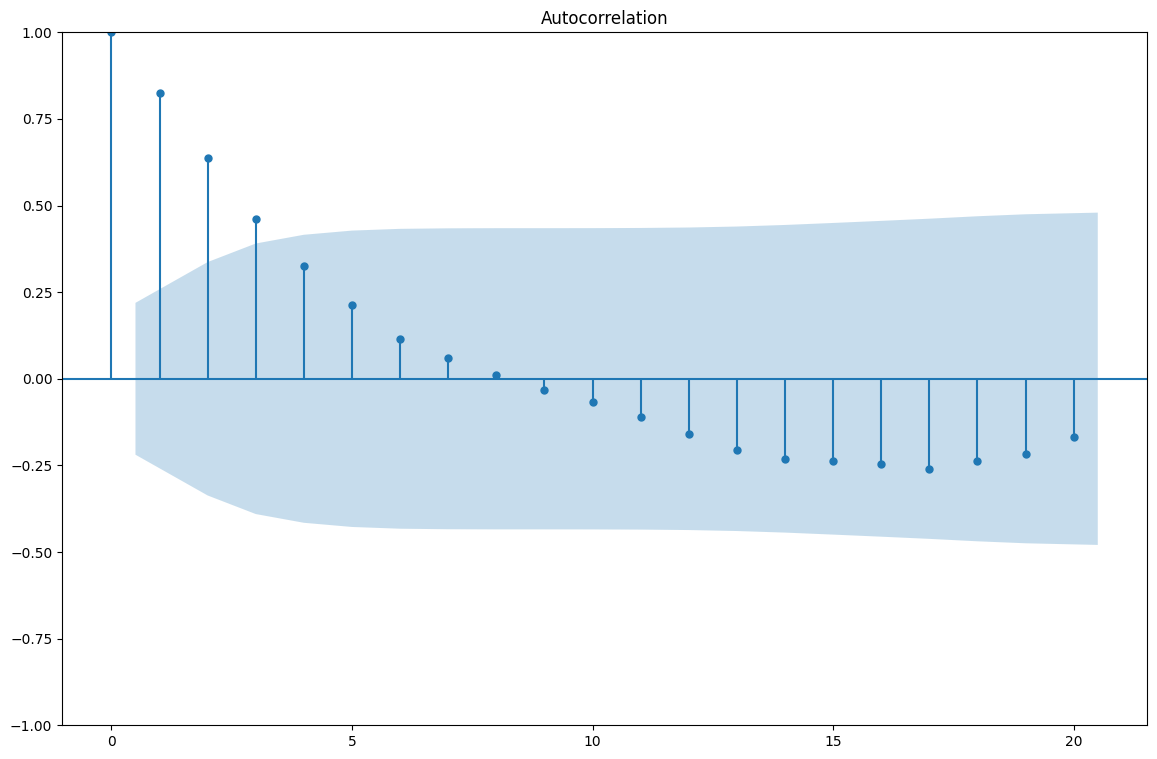

In [76]:
# Plot ACF & PACF
plot_pacf(train['sales_sum'])
plot_acf(train['sales_sum'])
plt.show()

## AIC
---

In [77]:
# function to get aic score, p, d, and q

def calculate_aic(data, num_p, num_d, num_q):
  # create empty df to store p, d, q, and aic score
  df1 = pd.DataFrame()

  # create empty list to store p, d, q
  pdq = [[], [], []]

  # create empty list to store aic score
  aic_score = []

  # looping to get p, d, q
  for lag_p in range(num_p + 1):
    for lag_d in range(num_d + 1):
      for lag_q in range(num_q + 1):
        # model definition
        model = SARIMAX(data, order=(lag_p, lag_d, lag_q))
        # model training
        result = model.fit()
        # filling empty list with aic score which generated from model training
        aic_score.append(result.aic)
        # filling empty list with lag_p, lag_d, and lag_q
        pdq[0].append(lag_p)
        pdq[1].append(lag_d)
        pdq[2].append(lag_q)

  # value placement to dataframe
  df1['AIC'] = aic_score
  df1['p'] = pdq[0]
  df1['d'] = pdq[1]
  df1['q'] = pdq[2]

  df1.sort_values('AIC', inplace=True)
  return df1

In [78]:
# Find best model of SARIMAX with combinations of p=1, d=0, q=2
calculate_aic(train['sales_sum'], 1, 0, 2)

,AIC,p,d,q
3,2013.118205,1,0,0
4,2014.925712,1,0,1
5,2016.932903,1,0,2
2,2289.552127,0,0,2
1,2302.388581,0,0,1
0,2356.972831,0,0,0


# III. Model Definition and Training
---

## SARIMAX WITH EXOGENOUS
---

In [79]:
# Define exogenous variable as qty_sum
exog_vars = train[['qty_sum']]

# 
model_sar_exog = SARIMAX(train['sales_sum'], order=(1,0,0), seasonal_order=(1,0,0,90), exog=exog_vars)

result_sar_exog = model_sar_exog.fit()

print("AIC Score: ", result_sar_exog.aic)

AIC Score:  1789.9266691568728


In [80]:
# Summary
result_sar_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          sales_sum   No. Observations:                   80
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 90)   Log Likelihood                -890.963
Date:                            Wed, 18 Jun 2025   AIC                           1789.927
Time:                                    18:10:32   BIC                           1799.455
Sample:                                04-01-2022   HQIC                          1793.747
                                     - 06-19-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
qty_sum      649.9057      6.475    100.368      0.000     637.214     662.597
ar.L1          0.6933      0.092      7.508      0.000       0.512       0.874
ar.S.L90       0.0003    221.000    1.5e-06      1.000    -433.151     433.152
sigma2      2.789e+08      0.001   2.49e+11      0.000    2.79e+08    2.79e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.24   Jarque-Bera (JB):                16.74
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.84
Prob(H) (two-sided):                  0.60   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.02e+26. Standard errors may be unstable.
"""

In [81]:
# Train prediction
pred_train_sar_exog = result_sar_exog.predict(start=train['sales_sum'].index[0], end=train['sales_sum'].index[-1], exog= exog_vars)
pred_train_sar_exog = pred_train_sar_exog.rename('predict')

# Train actual vs prediction
act_vs_pred_train_sar_exog = pd.concat([train['sales_sum'], pred_train_sar_exog], axis=1)
act_vs_pred_train_sar_exog

,sales_sum,predict
2022-04-01,635277.0,633008.117512
2022-04-02,673257.0,680074.593204
2022-04-03,737777.0,721658.554867
2022-04-04,630021.0,627364.502481
2022-04-05,685402.0,711040.025588
...,...,...
2022-06-15,553686.0,538013.949090
2022-06-16,556744.0,557578.239491
2022-06-17,482452.0,464448.338900
2022-06-18,465831.0,468519.088473


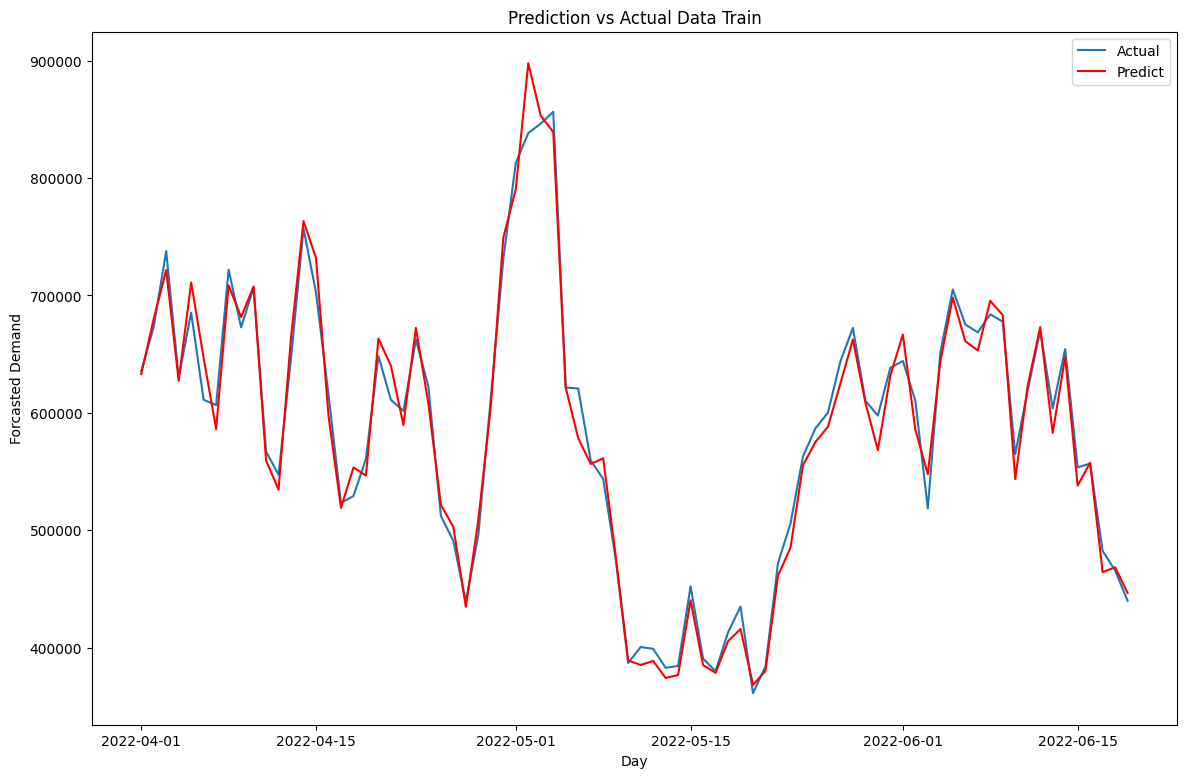

In [82]:
# Plot actual and predict data train
plt.plot(train['sales_sum'], label = 'Actual')
plt.plot(pred_train_sar_exog, color = 'red', label = 'Predict')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual Data Train')
plt.legend()
plt.show()

In [83]:
# Exogenous variable for test data define
exog_vars_test = test[['qty_sum']]

# Test prediction
pred_test_sar_exog = result_sar_exog.predict(start=test['sales_sum'].index[0], end=test['sales_sum'].index[-1], exog=exog_vars_test,  dynamic=False)
pred_test_sar_exog = pred_test_sar_exog.rename('predict')

# Concate with actual test-set
act_vs_pred_test_sar_exog = pd.concat([test['sales_sum'], pred_test_sar_exog], axis=1)
act_vs_pred_test_sar_exog

,sales_sum,predict
2022-06-20,498641.0,492358.005696
2022-06-21,509995.0,509043.865639
2022-06-22,520920.0,531392.512005
2022-06-23,416522.0,414332.829167
2022-06-24,437710.0,426827.205414
2022-06-25,468786.0,443375.516984
2022-06-26,523264.0,493826.051655
2022-06-27,462018.0,429317.571059
2022-06-28,459203.0,435050.425399


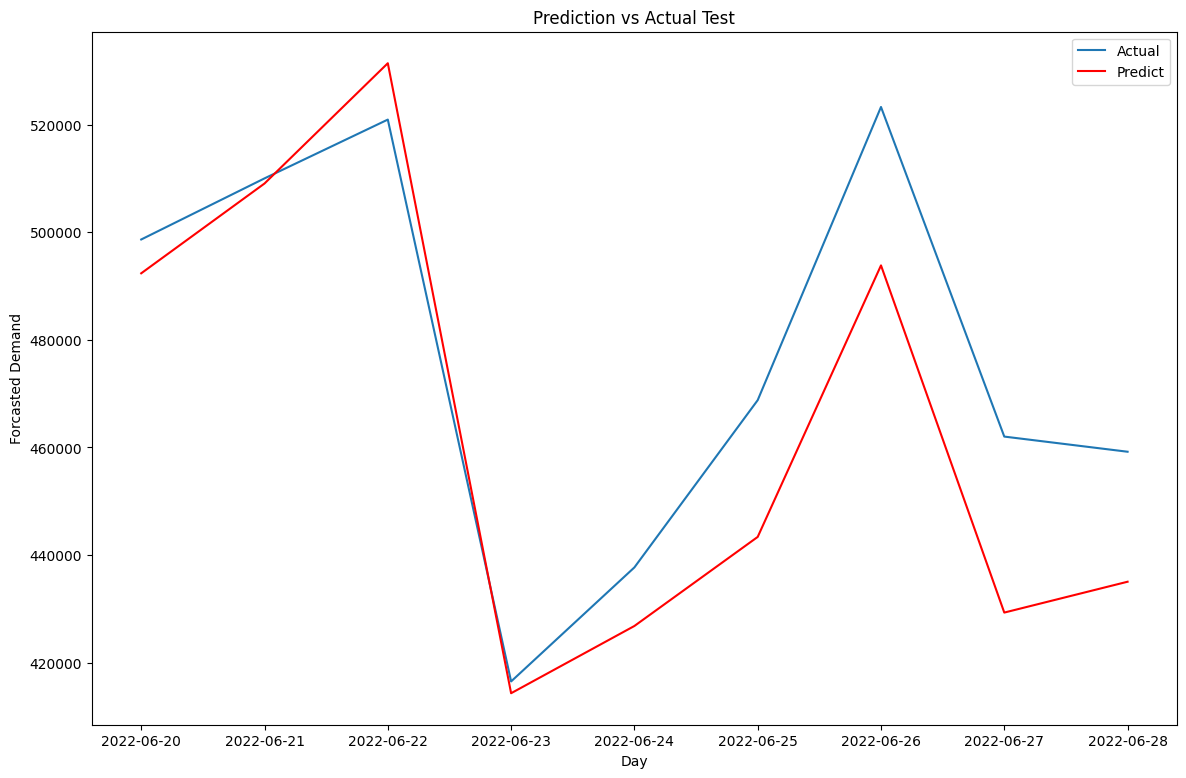

In [84]:
# Plot actual and predict data test
plt.plot(test['sales_sum'], label = 'Actual')
plt.plot(pred_test_sar_exog, color = 'red', label = 'Predict')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual Test')
plt.legend()
plt.show()

### Evaluation
---

In [85]:
# Evaluation Train
mae_train_sar_exog = mean_absolute_error(train['sales_sum'], pred_train_sar_exog)

# Evaluation Test
mae_test_sar_exog = mean_absolute_error(test['sales_sum'], pred_test_sar_exog)

# Print MAE train and test
print(f"MAE Train : {mae_train_sar_exog}")
print(f"MAE Test : {mae_test_sar_exog}")

MAE Train : 13105.851296145429
MAE Test : 15831.115665839947


In [86]:
# Evaluation Train
mape_train_sar_exog = mean_absolute_percentage_error(train['sales_sum'], pred_train_sar_exog)

# Evaluation Test
mape_test_sar_exog = mean_absolute_percentage_error(test['sales_sum'], pred_test_sar_exog)

# Print MAPE train and test
print(f"MAPE Train : {mape_train_sar_exog}")
print(f"MAPE Test : {mape_test_sar_exog}")

MAPE Train : 0.02224778465973868
MAPE Test : 0.033169472974351494


# IV. Model Saving
---

In [87]:
# Model saving .pickle
with open('model.pkl', 'wb') as model:
  pickle.dump(result_sar_exog, model)

In [88]:
# Last data saving
with open('data_test.pkl', 'wb') as data:
    pickle.dump(test, data)